In [1]:
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [ ]:
# import torch
# torch.cuda.is_available()

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

# Building a NARX Neural Network

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from src.file_loader import load_csv_files
# import matplotlib as mpl
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

In [3]:
# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [4]:
# List of file names
file_names = [
    '9171_20241001_N11507060127_ Rapid polarization-2.csv'
    ]

# print(f"Processing file: {file_names}")
dataframes = load_csv_files(file_names, '', 'deep learning assignment')


In [5]:
# Extract the DataFrame
data = dataframes['9171_20241001_N11507060127__Rapid_polarization-2_csv']

# Confirm it's a DataFrame
print(type(data))  # Should output <class 'pandas.core.frame.DataFrame'>

# Use the describe() method
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
       Time (HH:mm:ss.SSS) Channel     CH      V      A
count                16383   16341  16320  16320  16320
unique               16323   16321      2    142     16
top                   Step     CH1    CH1  2.926  2.251
freq                    21      21  16299   2120   5620


In [6]:
data.head()

,Time (HH:mm:ss.SSS),Channel,CH,V,A
0,11:45:54.513,0.780562,CH1,1.429,0.046
1,11:45:54.753,1.0206133,CH1,1.444,0.046
2,11:45:54.983,1.2505946,CH1,1.452,0.046
3,11:45:55.223,1.490689,CH1,1.457,0.046
4,11:45:55.453,1.7206743,CH1,1.461,0.046


In [7]:
data.dtypes

Time (HH:mm:ss.SSS)    object
Channel                object
CH                     object
V                      object
A                      object
dtype: object

In [8]:
# Convert `V` and `A` columns to numeric
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data['A'] = pd.to_numeric(data['A'], errors='coerce')

In [9]:
# Drop rows with NaN values in these columns if conversion fails
data = data.dropna(subset=['V', 'A'])

In [ ]:
# Select numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = data[numeric_cols]

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(numeric_data)

# Create a new DataFrame with scaled values
scaled_data = pd.DataFrame(scaled, columns=numeric_cols, index=data.index)

# # Optional: Combine with non-numeric columns
# non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64'])
# final_data = pd.concat([non_numeric_cols, scaled_data], axis=1)

# # Check the result
# print(final_data.head())

scaled_data.head()


## **NARX Neural Network Model**

NARX (Nonlinear Autoregressive with Exogenous Inputs) Neural Network model.

---

**1. NARX Model Overview**

The NARX model predicts the next value in a sequence based on past values of both the target variable (autoregressive terms) and exogenous (independent) variables. Mathematically, it is represented as:

\[
y(t) = f(y(t-1), y(t-2), ..., y(t-n), u(t-1), u(t-2), ..., u(t-m)) + e(t)
\]

Where:
- \(y(t)\): The target variable at time \(t\).
- \(y(t-1), y(t-2), ..., y(t-n)\): Previous values of the target variable (autoregressive terms).
- \(u(t-1), u(t-2), ..., u(t-m)\): Values of the exogenous input.
- \(e(t)\): The error term at time \(t\).
- \(f\): A nonlinear function approximated by a neural network.

In this project:
- **\(y\)**: Target column in your scaled dataset.
- **\(u\)**: The input sequence of past data.
- **Neural Network**: Used to model the nonlinear function \(f\).

---


### 1. Using Feedforward neural network (FNN) Implementation

**Mathematical explanation for the sequence function**

The function `create_narxffn_sequences` creates overlapping sliding windows from the dataset:

- **Mathematics**:
  - For each window of size \(L\) (sequence length):
    - **Inputs**: \([x_{t-L}, x_{t-L+1}, ..., x_{t-1}]\)
    - **Target**: \(x_t\)

- The function also flattens the data for simpler input into the dense network.

---



In [ ]:
def create_narxffn_sequences(input_data, target_column, sequence_length=1, flatten=False):
    """
    Generates sequences of input data and corresponding target labels from time-series data.

    This function slices the input data into subsequences of a specified length, where each subsequence 
    corresponds to a sequence of input features, and the target label is the value of the specified 
    target column at the point immediately following the subsequence.

    Parameters:
    ----------
    input_data : ndarray
        A 2D array or matrix containing the time-series data (with rows as time steps and columns as features).
        
    target_column : int
        The column index in the input data representing the target variable for which we are predicting.
        
    sequence_length : int, optional (default=1)
        The length of the sequence used as input for the prediction model.
        
    flatten : bool, optional (default=False)
        If True, flattens the input sequences into 1D arrays. If False, the sequences retain their original shape.

    Returns:
    -------
    np.ndarray, np.ndarray
        A tuple of two arrays:
        - The first array contains the input sequences, each of shape (sequence_length, features).
        - The second array contains the target labels corresponding to each sequence.

    Mathematical Explanation:
    -------------------------
    Let \( X_t \) represent the input data at time step \( t \), and \( Y_t \) represent the target value 
    at time step \( t \) from the column `target_column`. The function generates subsequences \( X_{t:t+L} \) 
    (where \( L \) is the `sequence_length`) and assigns the target value as \( Y_{t+L} \) (the value at the 
    next time step after the sequence). 

    The formula for generating the input-output pair is:
        Input sequence: \( X = [X_t, X_{t+1}, ..., X_{t+L-1}] \)
        Target value: \( Y = X_{t+L}[target_column] \)

    Example:
    --------
    input_data = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
    target_column = 1
    sequences, labels = create_sequences(input_data, target_column, sequence_length=2)
    """
    inputs = []
    targets = []
    data_size = len(input_data)
    
    for i in range(data_size-sequence_length):
        sequence = input_data[i:i+sequence_length]
        #print(type(sequence))
        label_position = i + sequence_length
        label = input_data[label_position][target_column]
        if flatten:
            inputs.append(sequence.flatten())
        else:
            inputs.append(sequence)
        targets.append(label)
        
    return np.array(inputs), np.array(targets)


In [ ]:
x, y = create_narxffn_sequences(scaled_data.to_numpy(), 1, 3, flatten=True)
x.shape, y.shape

((16296, 6), (16296,))

In [14]:
split_ratio = 0.25
split = int(len(x) * split_ratio)

x_train, x_valid = x[:-split], x[-split:]
y_train, y_valid = y[:-split], y[-split:]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

x_train shape: (12222, 6), y_train shape: (12222,)
x_valid shape: (4074, 6), y_valid shape: (4074,)


In [15]:
# Assuming x.shape[1] is the number of input features
narxffn_model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=(x.shape[1],)),
    layers.Dense(1, activation='relu')
])

# Corrected: Wrap the metrics argument in a list
narxffn_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']  # Wrap 'mae' in a list
)

# Adding an EarlyStopping callback
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
history = narxffn_model.fit(x,y, epochs=100, validation_split=0.2, verbose=1, callbacks=[callback])

Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0065 - mae: 0.0621 - val_loss: 0.0020 - val_mae: 0.0346
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4637e-04 - mae: 0.0230 - val_loss: 0.0013 - val_mae: 0.0246
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2769e-04 - mae: 0.0167 - val_loss: 6.9082e-04 - val_mae: 0.0152
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5842e-04 - mae: 0.0096 - val_loss: 4.1185e-04 - val_mae: 0.0026
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6432e-04 - mae: 0.0038 - val_loss: 3.8633e-04 - val_mae: 0.0055
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1929e-04 - mae: 0.0033 - val_loss: 3.9381e-04 - val_mae: 0.0040
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.4850e-04 - mae: 0.0036 - val_loss: 4.2622e-04 - val_mae: 0.0101
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8639e-04 - mae: 0.0042 - val_loss: 3.6554e-04 - val_mae: 0.0

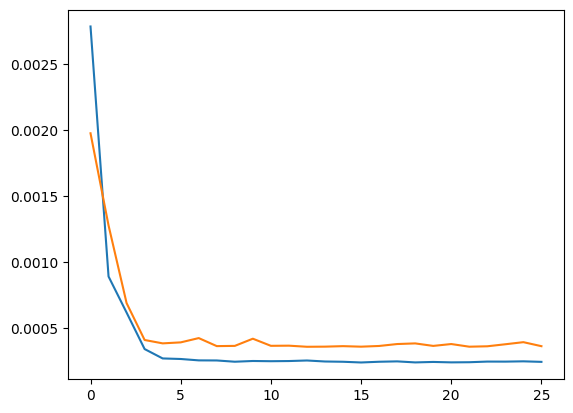

In [17]:
history.history['loss']

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [18]:
history.history['loss']

[0.0027828915044665337,
 0.0008919636020436883,
 0.0006192143191583455,
 0.00034320648410357535,
 0.00027232817956246436,
 0.00026818583137355745,
 0.0002576906408648938,
 0.00025702317361719906,
 0.0002475158544257283,
 0.0002530297788325697,
 0.0002513838990125805,
 0.00025264074793085456,
 0.00025678679230622947,
 0.00024924834724515676,
 0.00024719894281588495,
 0.0002418006770312786,
 0.0002472932974342257,
 0.000250116951065138,
 0.0002422965771984309,
 0.0002458214876241982,
 0.00024262467923108488,
 0.00024371528706979007,
 0.00024859668337740004,
 0.0002482757263351232,
 0.00025048485258594155,
 0.0002464431745465845]

In [19]:
predicted = narxffn_model(x)

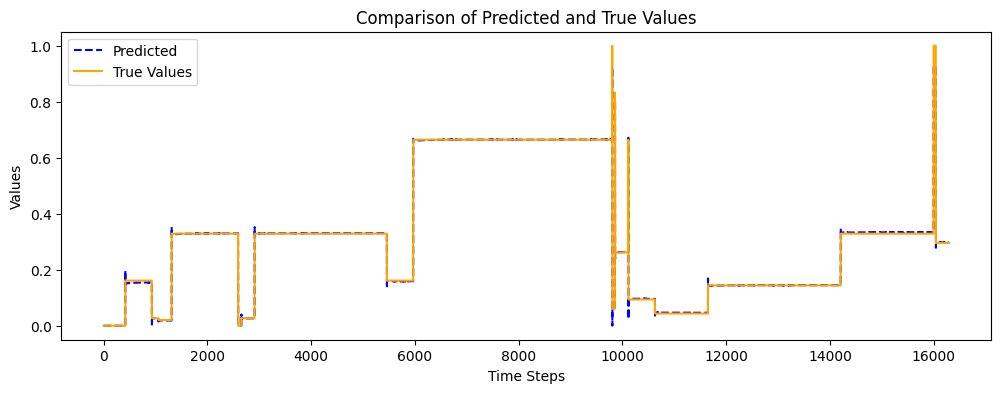

In [20]:
# Create the figure and set the size
plt.figure(figsize=(12, 4))

# Plot the predicted values
plt.plot(predicted, label="Predicted", color="blue", linestyle="--")

# Plot the true values
plt.plot(y, label="True Values", color="orange", linestyle="-")

# Add a title and labels
plt.title("Comparison of Predicted and True Values")
plt.xlabel("Time Steps")
plt.ylabel("Values")

# Add a legend to distinguish the lines
plt.legend()

# Show the plot
plt.show()


In [21]:
narxffn_model.evaluate(x,y)

510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4363e-04 - mae: 0.0020


[0.0002550638164393604, 0.0023407498374581337]

In [22]:
# Make predictions
y_prednarxffn = narxffn_model.predict(x_valid)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


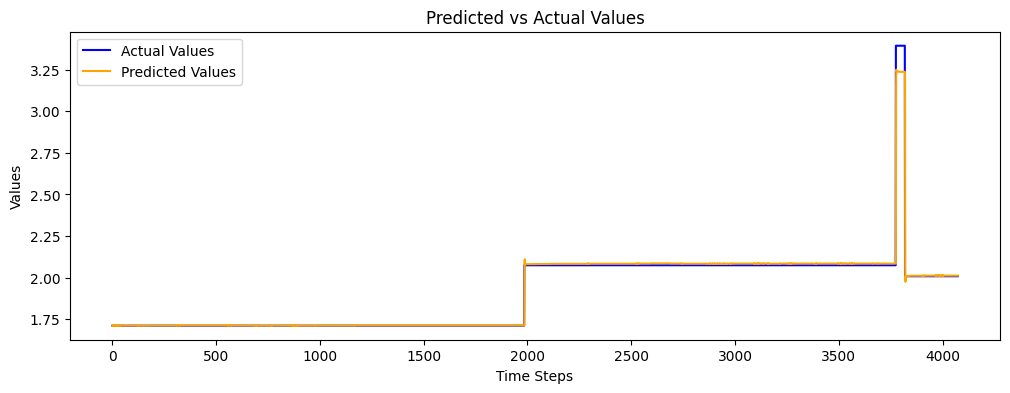

In [23]:
# Reshape y_valid and y_prednarxffn to be 2D arrays
y_valid_reshaped = y_valid.reshape(-1, 1)
y_prednarxffn_reshaped = y_prednarxffn.reshape(-1, 1)

# Rescale back to original values for comparison
y_valid_rescaled = scaler.inverse_transform(
    np.hstack((y_valid_reshaped, np.zeros_like(y_valid_reshaped)))
)
y_prednarxffn_rescaled = scaler.inverse_transform(
    np.hstack((y_prednarxffn_reshaped, np.zeros_like(y_prednarxffn_reshaped)))
)

# Plot predictions vs actuals
plt.figure(figsize=(12, 4))
plt.plot(y_valid_rescaled[:, 0], label="Actual Values", color="blue")
plt.plot(y_prednarxffn_rescaled[:, 0], label="Predicted Values", color="orange")
plt.title("Predicted vs Actual Values")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.show()


### 2. Classical NARXNN Implementation

**Mathematical explanation for the sequence function**

The function `create_narx_sequences` creates overlapping sliding windows from the dataset:

- **Mathematical Explanation:**

Let \( X_t \) represent the input data at time step \( t \), and \( Y_t \) represent the target variable at time step \( t \).

For each sequence, the function creates:
- **AR terms**: \( AR_t = [Y_{t-1}, Y_{t-2}, ..., Y_{t-k}] \) (past values of the target column).
- **Exogenous terms**: \( X_{exog} = [X_{t-1}, X_{t-2}, ..., X_{t-k}] \) (past values of all input variables except the target).

The resulting input for time step \( t \) is:

\[
\text{Input} = [AR_t, X_{exog}]
\]

The target for this input sequence is the future target values over the output lags:

\[
Y_{t+1:t+\text{output\_lags}}
\]

---



In [ ]:
def create_narx_sequences(data, target_column, input_lags=3, output_lags=1):
    """
    Generates sequences with explicit autoregressive (AR) terms and exogenous (input) terms for NARXNN 
    (Nonlinear AutoRegressive with eXogenous inputs) models.

    This function creates sequences where the inputs include both past values of the target (AR terms) 
    and past values of all other features (exogenous inputs). The outputs are the future values of the 
    target variable over the specified output lags.

    Parameters:
    ----------
    data : ndarray
        A 2D array containing the time-series data, where each row represents a time step and each column represents a feature.
        
    target_column : int
        The column index of the target variable for prediction.

    input_lags : int, optional (default=3)
        The number of past time steps to include in the input sequence for both AR and exogenous terms.

    output_lags : int, optional (default=1)
        The number of future time steps for which predictions are made.

    Returns:
    -------
    np.ndarray, np.ndarray
        A tuple containing:
        - The first array contains the input sequences (with both AR and exogenous inputs).
        - The second array contains the future target values (over `output_lags` time steps).

    Mathematical Explanation:
    -------------------------
    Let \( X_t \) represent the input data at time step \( t \), and \( Y_t \) represent the target variable at time step \( t \).
    For each sequence, the function creates:
    - AR terms: \( AR_t = [Y_{t-1}, Y_{t-2}, ..., Y_{t-k}] \) (past values of the target column).
    - Exogenous terms: \( X_{exog} = [X_{t-1}, X_{t-2}, ..., X_{t-k}] \) (past values of all input variables except the target).

    The resulting input for time step \( t \) is: 
        \( Input = [AR_t, X_{exog}] \)

    The target for this input sequence is the future target values over the output lags:
        \( Y_{t+1:t+output\_lags} \)

    Example:
    --------
    data = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
    target_column = 1
    input_lags = 2
    output_lags = 1
    sequences, labels = create_narx_sequences(data, target_column, input_lags=input_lags, output_lags=output_lags)
    """
    inputs, targets = [], []
    n_samples = len(data)

    for i in range(input_lags, n_samples - output_lags):
        # AR terms (past values of the target)
        ar_terms = data[i - input_lags:i, target_column]
        
        # Exogenous terms (past values of the other input variables)
        exog_terms = data[i - input_lags:i, :]
        
        # Concatenate AR terms and exogenous terms
        # inputs.append(np.hstack([ar_terms, exog_terms.flatten()]))
        combined = np.hstack([ar_terms.reshape(-1, 1), exog_terms])
        inputs.append(combined)  # Keep shape as (input_lags, features)
        
        # Future target values for output lags
        targets.append(data[i:i + output_lags, target_column])
    
    return np.array(inputs), np.array(targets)


In [26]:
# Define target (e.g., 'V' column as the target variable)
target_column = 0  # 'V' is the first column
input_lags = 3  # Number of past steps to include
output_lags = 1  # Predict one step ahead

x, y = create_narx_sequences(scaled_data.to_numpy(), target_column, input_lags, output_lags)

In [27]:
# Train-test split
split_ratio = 0.25
split = int(len(x) * (1 - split_ratio))
x_train, x_valid = x[:split], x[split:]
y_train, y_valid = y[:split], y[split:]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

x_train shape: (12221, 3, 3), y_train shape: (12221, 1)
x_valid shape: (4074, 3, 3), y_valid shape: (4074, 1)


In [28]:
# Check shapes after fixing
print(f"x_train shape: {x_train.shape}")  # Expected: (samples, timesteps, features)
print(f"y_train shape: {y_train.shape}")  # Expected: (samples, output_lags)

x_train shape: (12221, 3, 3)
y_train shape: (12221, 1)


In [29]:
# Define the NARXNN model
narx_model = keras.Sequential([
    layers.LSTM(32, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])),
    layers.Dense(16, activation='tanh'),
    layers.Dense(y_train.shape[1], activation='relu')  # Output layer
])

# Compile the model
narx_model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=['mae'])

# Train the model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
history = narx_model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_valid, y_valid),
    callbacks=[callback],
    verbose=1
)


Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0255 - mae: 0.0802 - val_loss: 3.2675e-04 - val_mae: 0.0101
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8768e-04 - mae: 0.0070 - val_loss: 2.5174e-04 - val_mae: 0.0054
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4581e-04 - mae: 0.0040 - val_loss: 2.2873e-04 - val_mae: 0.0029
Epoch 4/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.4666e-04 - mae: 0.0038 - val_loss: 2.2401e-04 - val_mae: 0.0029
Epoch 5/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8727e-04 - mae: 0.0040 - val_loss: 2.9129e-04 - val_mae: 0.0093
Epoch 6/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.4251e-04 - mae: 0.0052 - val_loss: 2.0705e-04 - val_mae: 0.0027
Epoch 7/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9655e-04 - mae: 0.0042 - val_loss: 1.9970e-04 - val_mae: 0.0027
Epoch 8/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1889e-04 - mae: 0.0043 - val_loss: 1.9207e-04 - val_

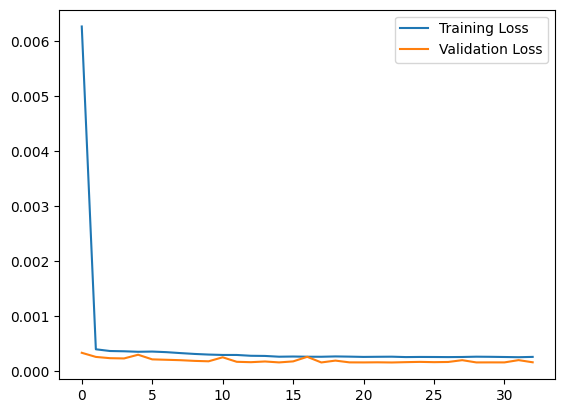

In [31]:

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
predicted = narx_model(x)

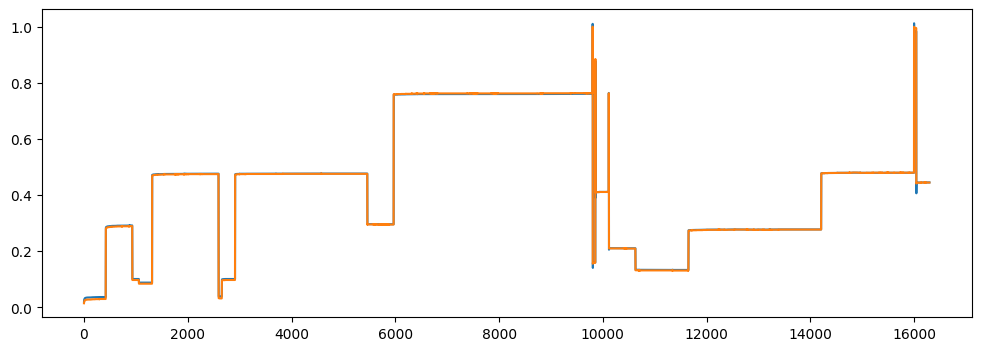

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(predicted)
plt.plot(y)

In [35]:
# Make predictions
y_prednarx = narx_model.predict(x_valid)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


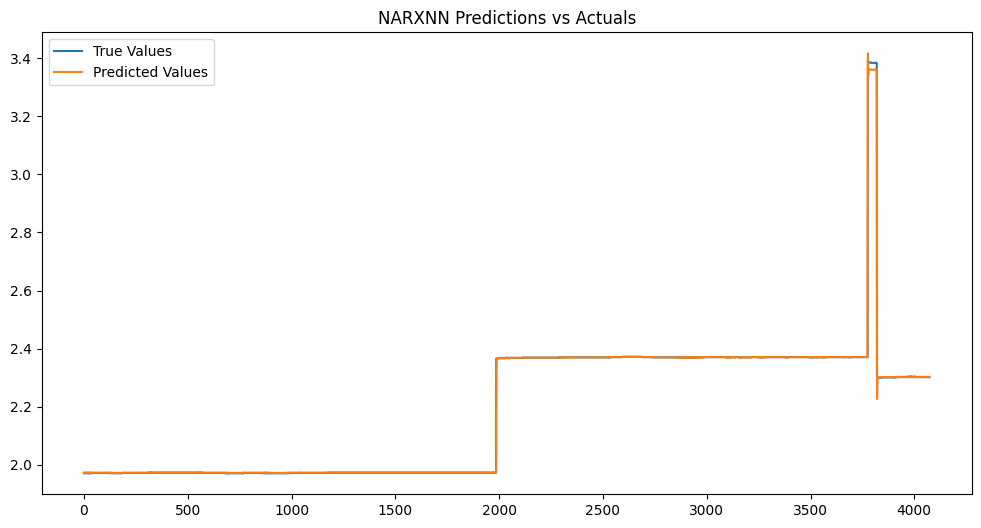

In [36]:
# Rescale back to original values for comparison
y_valid_rescaled = scaler.inverse_transform(np.hstack((y_valid, np.zeros_like(y_valid))))
y_prednarx_rescaled = scaler.inverse_transform(np.hstack((y_prednarx, np.zeros_like(y_prednarx))))

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(y_valid_rescaled[:, 0], label='True Values')
plt.plot(y_prednarx_rescaled[:, 0], label='Predicted Values')
plt.legend()
plt.title('NARXNN Predictions vs Actuals')
plt.show()

### Model Comparison

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For FNN
mae_fnn = mean_absolute_error(y_valid_rescaled[:, 0], y_prednarxffn_rescaled[:, 0])
mse_fnn = mean_squared_error(y_valid_rescaled[:, 0], y_prednarxffn_rescaled[:, 0])

# For NARXNN
mae_narx = mean_absolute_error(y_valid_rescaled[:, 0], y_prednarx_rescaled[:, 0])
mse_narx = mean_squared_error(y_valid_rescaled[:, 0], y_prednarx_rescaled[:, 0])

# Print results
print(f"FNN - MAE: {mae_fnn}, MSE: {mse_fnn}")
print(f"NARXNN - MAE: {mae_narx}, MSE: {mse_narx}")

# Metrics (MAE, MSE): Which model has the lowest errors? Classical NARXNN?


FNN - MAE: 0.2717857149816577, MSE: 0.07421483914528387
NARXNN - MAE: 0.0015799434956348527, MSE: 0.0005805882827014782
